In [1]:
import nltk
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from textblob import TextBlob as tb 
from datetime import datetime

In [2]:
# data consists of all posts and comments on ENBD fb page since 2015/5/29, Source: Facebook Graph API
data = pd.read_csv("facebook_data.csv", sep = ";")
data = data.dropna(axis = 0)
data.head()

,level,id,parent_id,object_id,object_type,query_status,query_time,query_type,created_time,message
1,1,2,1,254094394708288_1695660977218282,data,fetched (200),2018-07-08 22:48:52.398990,Facebook:<user>/posts,2018-07-08T16:00:01+0000,We are bringing to you another session of #Ask...
2,1,3,1,254094394708288_1693988240718889,data,fetched (200),2018-07-08 22:48:52.398990,Facebook:<user>/posts,2018-07-07T16:00:00+0000,Do you know how far your food travels from far...
3,1,4,1,254094394708288_1692259267558453,data,fetched (200),2018-07-08 22:48:52.398990,Facebook:<user>/posts,2018-07-06T12:00:01+0000,Grab your coffee on the move. Make contactless...
4,1,5,1,254094394708288_1690904381027275,data,fetched (200),2018-07-08 22:48:52.398990,Facebook:<user>/posts,2018-07-05T15:01:36+0000,You can win an iPhone X easily! Here is how yo...
5,1,6,1,254094394708288_1689382777846102,data,fetched (200),2018-07-08 22:48:52.398990,Facebook:<user>/posts,2018-07-04T16:00:01+0000,Explore the best places to visit this year wit...


In [3]:
f = lambda x: datetime.strptime(x.split("T")[0], "%Y-%m-%d")
data["created_datetime"] = data.created_time.map(f)

In [4]:
#Create dataframes for posts and comments
posts = pd.DataFrame(data[["created_datetime","message"]][data.level == 1].values, columns =["date","Text"])
comments = pd.DataFrame(data[["created_datetime","message"]][data.level == 2].values, columns = ["date","Text"])

In [5]:
#Sample posts 
posts.Text.values.tolist()[:5]

['We are bringing to you another session of #AskEmiratesNBD . This session will be with the Experts from our Mobile Banking team. We will be going live tomorrow, Monday July 9th at 1 pm on our Facebook, Instagram, and Twitter channels. Be sure to tune in and ask us all your questions.  سنقدّم إليكم فقرة جديدة من #AskEmiratesNBD حيث ستكون هذه الفقرة مع فريق خدماتنا المصرفية عبر الهاتف. سنكون على الهواء مباشرة يوم الإثنين9 يوليو في تمام الساعة 1 ظهراً على الفيسبوك والإنستغرام والتويتر. تأكدوا من إرسال أسئلتكم إلينا',
 'Do you know how far your food travels from farm to plate? Reduce your food miles and shop local #GoGreen - هل تعرف إلى أي مدى ينتقل طعامك من المزرعة إلى الطبق؟ قلل الأميال الغذائية الخاصة بك وتسوق محليا  #GoGreen',
 'Grab your coffee on the move. Make contactless payments with your card or phone. Use Emirates NBD Pay, Apple Pay or Samsung Pay for a quick and secure checkout. - احصل على طلب القهوة الخاص بك على الفور. استخدم الدفعات بتقنية عدم التلامس مع بطاقاتنا أو جهازك ال

In [6]:
#Sample comments
comments.Text.values[5:10]

array([ "Yes NBD no one called me to fix the activation issue till now !!!! I just received new reminder to pay (du bill) or they will disconnect the service!!  But don't worry I will use the cash option with du in order to find at least mobile number to contact such a bad service from your bank !!!!!!!",
       "Very bad experience. I would never expect for a card activation to take more than 11 days . My credit card was hacked so I requested a new card since 26th of last month till now it's not activated yet. I don't understand why each update is requested separately and each requires 2 to 3 working days. I 've been on the phone with the bank for 1 hour every day  and still getting no where.  I tried the ATM option and to visit the mirdif branch for 3 times!!!   They asked me yestrday to try the online banking in order to activate the card and I will start receiving delay charges from Dewa, du, mpower and I can't make hotels reservations for my vacation trip and the prices going to b

In [7]:
#Clean text for sentiment analysis
alphabet = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
alphabet.append(" ")

def isenglish(word):
    r = [letter for letter in list(word) if letter in alphabet]
    if len(r)< len(word): return False
    else: return True

def clean(text):
    words = [word for word in nltk.word_tokenize(text) if word.isalpha()]
    english_words = [x for x in words if isenglish(x)]
    return " ".join(english_words)

posts["Clean Text"] = posts["Text"].map(clean)
comments["Clean Text"] = comments["Text"].map(clean)

In [20]:
# The textblob library consists of a pretrained Naive Bayes Analyser
polarity = lambda x : tb(x).sentiment.polarity
subjectivity = lambda x : tb(x).sentiment.subjectivity

comments["polarity"] = comments["Clean Text"].map(polarity)
comments["subjectivity"] = comments["Clean Text"].map(subjectivity)
comments["sentiment_index"] = list(zip(comments.subjectivity.values, comments.polarity.values))

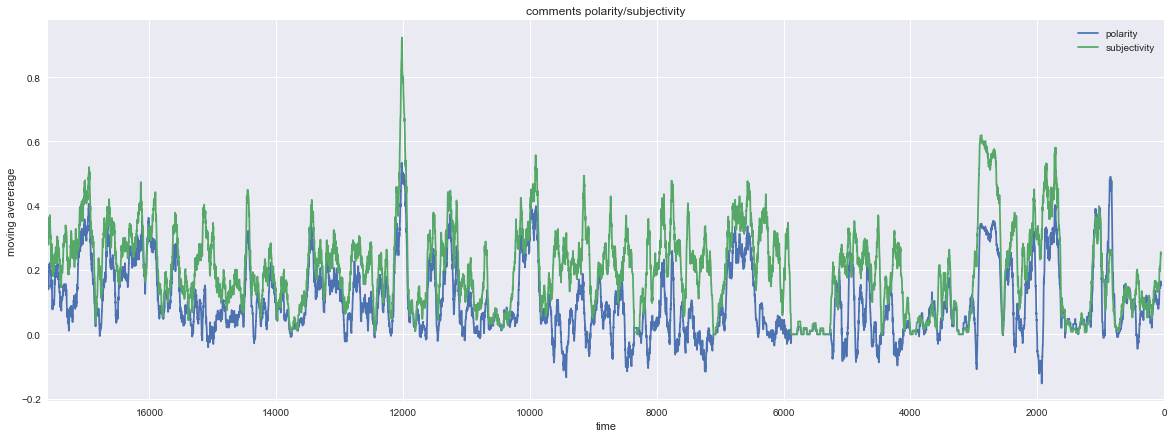

In [9]:
# Plot sentiment indices along time
x = comments[["polarity", "subjectivity"]]
X = pd.DataFrame.rolling(x,window = 50).mean()[::-1]
X.plot(figsize = (20,7))
plt.title("comments polarity/subjectivity")
plt.xlabel("time")
plt.ylabel("moving avererage")
plt.show()

In [10]:
#Define sentiment using sentiment indices computed above
def sentiment(index):
    subjectivity, polarity = index[0], index[1]
    if subjectivity > 0.2:
        if polarity > 0.1: return "Positive"
        else: return "Negetive"
    else: return "Neutral"

comments["sentiment"] = comments["sentiment_index"].map(sentiment)

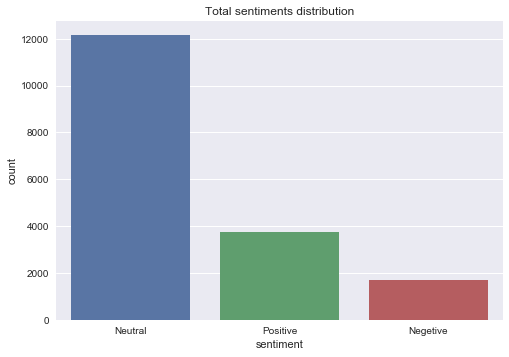

In [11]:
# See how sentiments are distributed
sns.countplot(comments['sentiment'],label="Count")
plt.title("Total sentiments distribution")
plt.show()

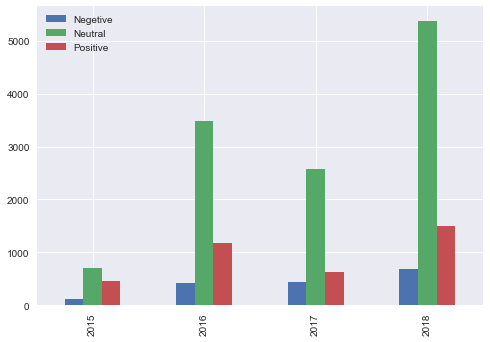

In [12]:
# Distribution of sentiments across years
to_year = lambda x : x.strftime('%Y')
comments["year"] = comments["date"].map(to_year)

years = ['2015','2016','2017','2018']
dictio = {}

for sent in ['Positive','Negetive','Neutral']:
    dictio[sent] = [len(comments["sentiment"][comments["sentiment"] == sent]
                         [comments["year"] == year]) for year in years]

df = pd.DataFrame(dictio, index = years)
df.plot(kind = 'bar')
plt.show()

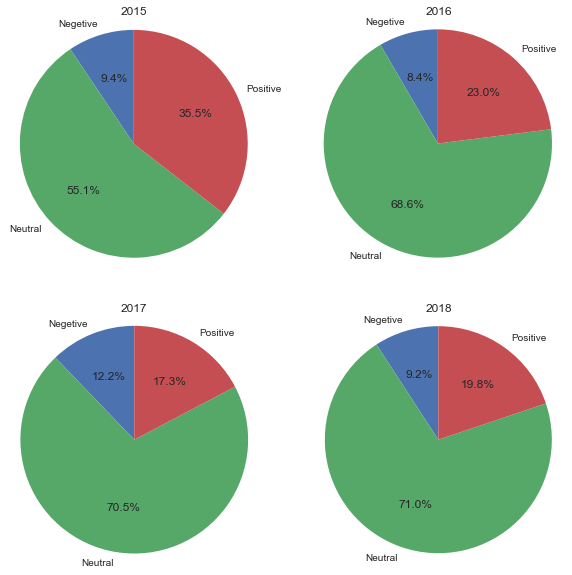

In [13]:
# Pie chart of sentiments distribution across years
labels = 'Negetive', 'Neutral', 'Positive'
fig0 = plt.figure(figsize = (10,10))
ax = [None]*len(years)
for i in range(len(years)):
    ax[i] = fig0.add_subplot(2,2,i+1)
    
for year in years:
    sizes = df.loc[year]
    index = years.index(year)
    ax[index].pie(sizes, labels=labels, autopct='%1.1f%%', startangle = 90)
    ax[index].axis('equal')
    ax[index].set_title(year)
    
plt.show()

In [14]:
# Week-wise distribution of sentiments

start , end = comments["date"].values[-1], comments["date"].values[0]
index = pd.date_range(start,end, freq = 'w')

dict_data = {}
for sentiment in ["Positive", "Negetive","Neutral"]:
    dict_data[sentiment] = [len(comments["sentiment"][comments["sentiment"] == sentiment]
         [comments["date"] > index[i]][comments["date"] < index[i+1]]) 
             for i in range(len(index)-1)]


frame = pd.DataFrame(dict_data, index = index[1:].strftime('%Y-%m-%d'))

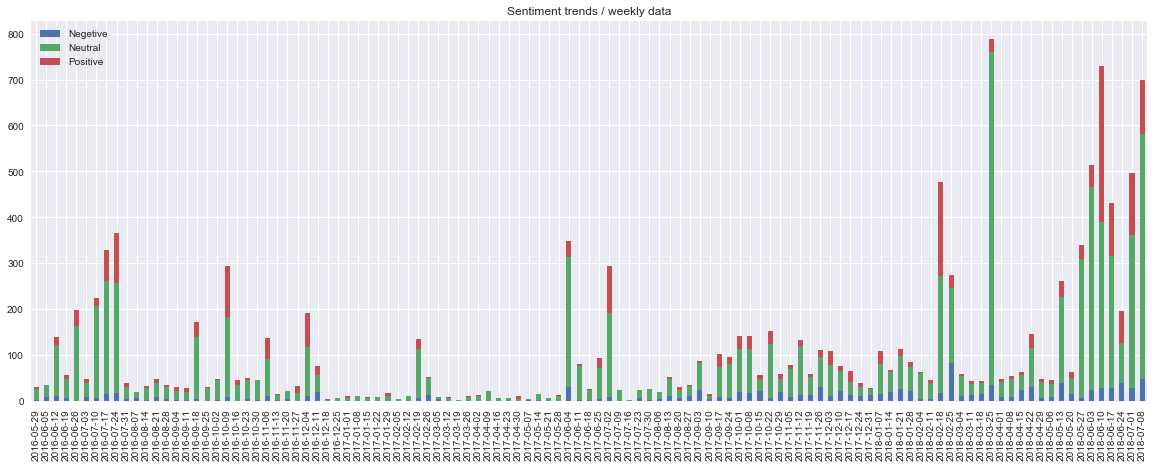

In [15]:
fig1 = plt.figure()
frame.plot(figsize = (20,7), kind = "bar", stacked = "True")
plt.title("Sentiment trends / weekly data")
plt.show()

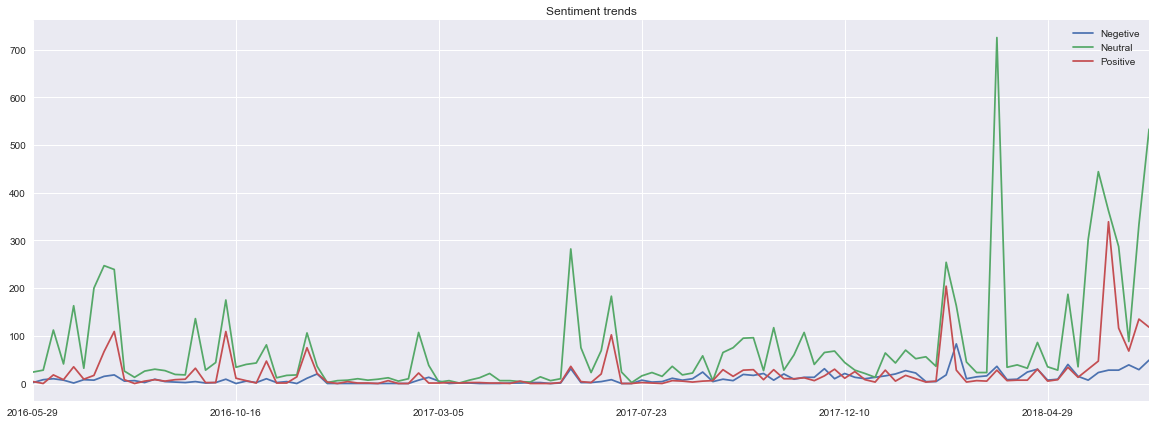

In [16]:
# Same plot - continous
frame.plot(figsize = (20,7))
plt.title("Sentiment trends")
plt.show()

In [17]:
# Collect words and phrases occurring in high sentiment comments
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

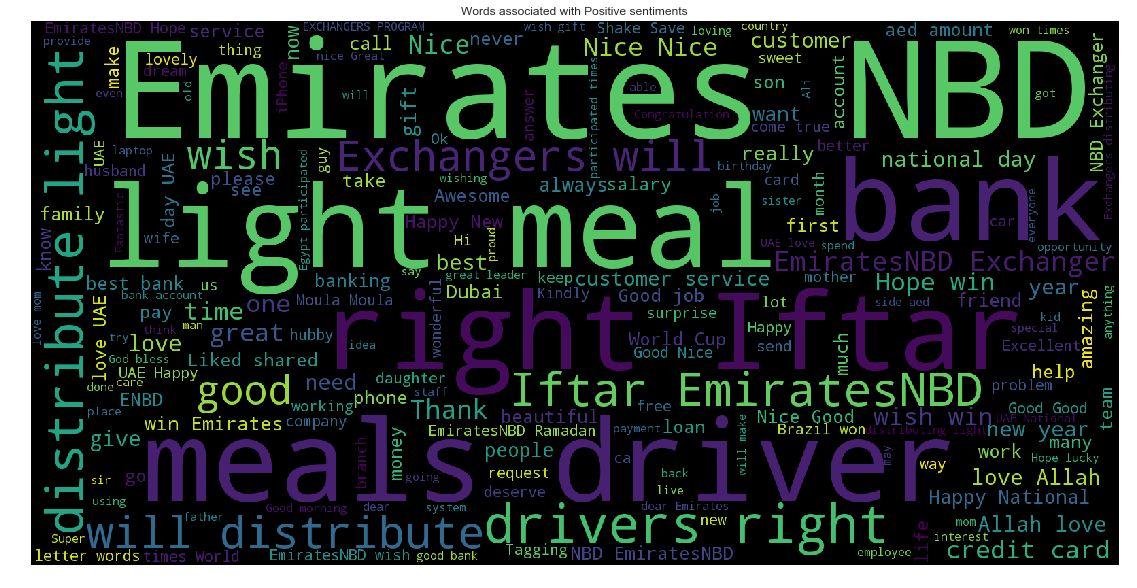

In [18]:
# Words and phrases occuring in positive sentiment comments
positive_sentiment_words = " ".join(comments["Clean Text"][comments["sentiment"] == "Positive"].values.tolist())

wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords = stopwords,  
                          max_words=200,
                          max_font_size=200, 
                          random_state=42
                         ).generate(positive_sentiment_words)
#print(wordcloud)
fig2 = plt.figure(figsize = (20,10))
plt.imshow(wordcloud)
plt.title("Words associated with Positive sentiments")
plt.axis("off")
plt.show()


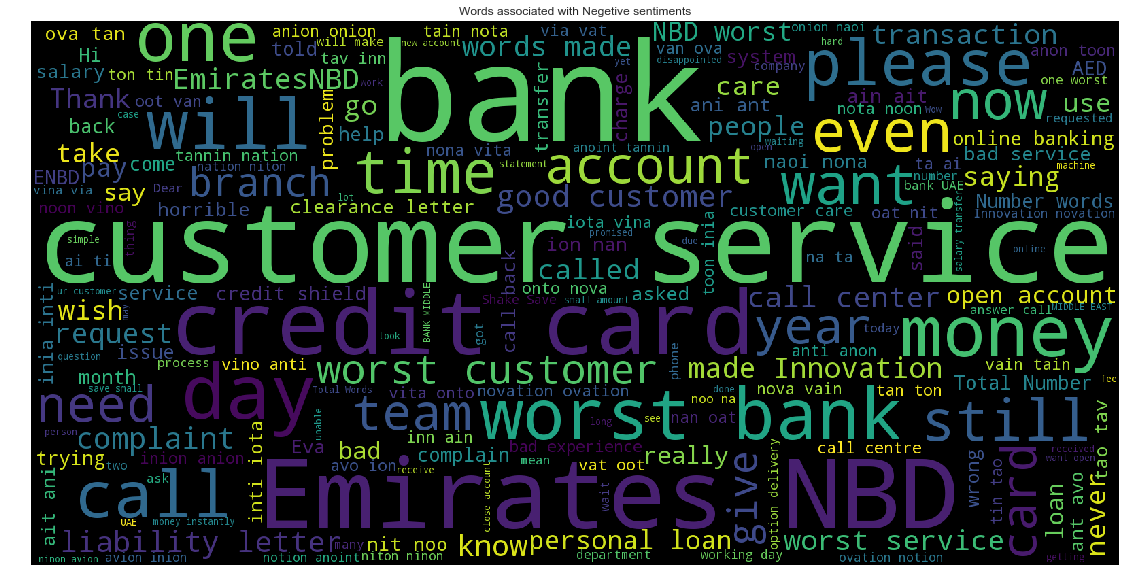

In [19]:
# Words and phrases occurring in negetive sentiment comments
negetive_sentiment_words = " ".join(comments["Clean Text"][comments["sentiment"] == "Negetive"].values.tolist())

wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords = stopwords,  
                          max_words=200,
                          max_font_size=200, 
                          random_state=42
                         ).generate(negetive_sentiment_words)
#print(wordcloud)
fig3 = plt.figure(figsize = (20,10))
plt.imshow(wordcloud)
plt.title("Words associated with Negetive sentiments")
plt.axis("off")
plt.show()
